In [267]:
#!pip install yfinance
#!pip install pandas-ta

In [268]:
import requests
import bs4 as bs
import pickle

import datetime as dt
import os

import pandas as pd
import pandas_datareader.data as pdr
import pandas_ta as ta

import numpy as np

import math

import yfinance as yf



In [269]:
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, KBinsDiscretizer
#import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# GET THE TRADING DATA

In [270]:
#SPX500 data

df_analisys = yf.download('^GSPC',period="30d", interval="15m")
#df_analisys = yf.download('^GSPC', interval="5m", start="2022-02-16", end="2022-03-03")

df_analisys = df_analisys.reset_index()

print(df_analisys.shape)
df_analisys

[*********************100%***********************]  1 of 1 completed
(781, 7)


,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-01-28 09:30:00-05:00,4336.189941,4342.990234,4299.500000,4300.069824,4300.069824,100494632
1,2022-01-28 09:45:00-05:00,4300.040039,4310.029785,4292.979980,4297.450195,4297.450195,178147219
2,2022-01-28 10:00:00-05:00,4298.410156,4320.919922,4292.459961,4315.200195,4315.200195,125595455
3,2022-01-28 10:15:00-05:00,4315.509766,4335.979980,4314.470215,4318.759766,4318.759766,114976511
4,2022-01-28 10:30:00-05:00,4319.660156,4325.729980,4305.479980,4307.200195,4307.200195,106622310
...,...,...,...,...,...,...,...
776,2022-03-11 15:00:00-05:00,4235.319824,4235.560059,4227.129883,4227.700195,4227.700195,61670000
777,2022-03-11 15:15:00-05:00,4227.660156,4232.430176,4224.000000,4224.069824,4224.069824,71619000
778,2022-03-11 15:30:00-05:00,4224.029785,4224.029785,4214.399902,4215.669922,4215.669922,108435000
779,2022-03-11 15:45:00-05:00,4215.759766,4217.229980,4213.859863,4213.919922,4213.919922,10454000


In [271]:
df_analisys.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [272]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys.to_pickle(DIR_OUTPUTS + 'df_spx500_15m_raw' + '.pkl')
print(df_analisys.shape)

(781, 7)


In [273]:
#df_analisys[ (df_analisys['Datetime']>=dt.datetime(2022,3,3,15,30))]

# Candles computations

In [274]:
#Fixes the trading date
df_analisys['Datetime'] = df_analisys['Datetime'].dt.tz_localize(None)
df_analisys['Datetime']

0     2022-01-28 09:30:00
1     2022-01-28 09:45:00
2     2022-01-28 10:00:00
3     2022-01-28 10:15:00
4     2022-01-28 10:30:00
              ...        
776   2022-03-11 15:00:00
777   2022-03-11 15:15:00
778   2022-03-11 15:30:00
779   2022-03-11 15:45:00
780   2022-03-11 15:46:21
Name: Datetime, Length: 781, dtype: datetime64[ns]

In [275]:
df_analisys['date'] = df_analisys['Datetime'].apply(lambda x: x.date())
df_analisys['date']

0      2022-01-28
1      2022-01-28
2      2022-01-28
3      2022-01-28
4      2022-01-28
          ...    
776    2022-03-11
777    2022-03-11
778    2022-03-11
779    2022-03-11
780    2022-03-11
Name: date, Length: 781, dtype: object

In [276]:
#Computes body sizes

df_analisys['body_size'] = df_analisys['Close'] - df_analisys['Open']
df_analisys['abs_body_size'] = abs(df_analisys['body_size'])
df_analisys['upper_tail_size'] = df_analisys['High'] - df_analisys[['Open','Close']].max(axis=1)
df_analisys['lower_tail_size'] = df_analisys[['Open','Close']].min(axis=1) - df_analisys['Low']

df_analisys[0:50]

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size
0,2022-01-28 09:30:00,4336.189941,4342.990234,4299.500000,4300.069824,4300.069824,100494632,2022-01-28,-36.120117,36.120117,6.800293,0.569824
1,2022-01-28 09:45:00,4300.040039,4310.029785,4292.979980,4297.450195,4297.450195,178147219,2022-01-28,-2.589844,2.589844,9.989746,4.470215
2,2022-01-28 10:00:00,4298.410156,4320.919922,4292.459961,4315.200195,4315.200195,125595455,2022-01-28,16.790039,16.790039,5.719727,5.950195
3,2022-01-28 10:15:00,4315.509766,4335.979980,4314.470215,4318.759766,4318.759766,114976511,2022-01-28,3.250000,3.250000,17.220215,1.039551
4,2022-01-28 10:30:00,4319.660156,4325.729980,4305.479980,4307.200195,4307.200195,106622310,2022-01-28,-12.459961,12.459961,6.069824,1.720215
5,2022-01-28 10:45:00,4307.430176,4346.779785,4306.709961,4346.759766,4346.759766,111561108,2022-01-28,39.329590,39.329590,0.020020,0.720215
6,2022-01-28 11:00:00,4346.879883,4355.490234,4335.549805,4354.939941,4354.939941,93686019,2022-01-28,8.060059,8.060059,0.550293,11.330078
7,2022-01-28 11:15:00,4354.419922,4370.029785,4354.419922,4363.700195,4363.700195,94135855,2022-01-28,9.280273,9.280273,6.329590,0.000000
8,2022-01-28 11:30:00,4363.660156,4374.810059,4357.160156,4366.439941,4366.439941,84135000,2022-01-28,2.779785,2.779785,8.370117,6.500000
9,2022-01-28 11:45:00,4365.979980,4383.910156,4364.509766,4382.939941,4382.939941,72170000,2022-01-28,16.959961,16.959961,0.970215,1.470215


In [277]:
#Computes candles color
df_analisys['body_disposal']=0
df_analisys.loc[df_analisys['body_size']>0,'body_disposal'] = 1
df_analisys.loc[df_analisys['body_size']<0,'body_disposal'] = 0

print(df_analisys['body_disposal'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))




   index  body_disposal
1      0            388
0      1            393


# MACD and EMA indicators

In [278]:
# # Calculate MACD values using the pandas_ta library
df_macd = df_analisys.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
df_macd


,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
776,-3.807217,-2.172065,-1.635153
777,-5.001556,-2.693123,-2.308433
778,-6.550371,-3.393550,-3.156821
779,-7.828783,-3.737570,-4.091213


In [279]:
ewm50 = df_analisys['Close'].ewm(span=50, adjust=False, min_periods=50).mean()
ewm200 = df_analisys['Close'].ewm(span=200, adjust=False, min_periods=200).mean()

df_macd['ewm50'] = ewm50
df_macd['ewm200'] = ewm200

#df_analisys_01['ewm50'] = ewm50
#df_analisys_01['ewm200'] = ewm200

df_analisys['diff_ewm50'] = df_analisys['Close'] - ewm50
df_analisys['diff_ewm200'] = df_analisys['Close'] - ewm200

df_analisys

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2022-01-28 09:30:00,4336.189941,4342.990234,4299.500000,4300.069824,4300.069824,100494632,2022-01-28,-36.120117,36.120117,6.800293,0.569824,0,NaN,NaN,NaN,NaN,NaN
1,2022-01-28 09:45:00,4300.040039,4310.029785,4292.979980,4297.450195,4297.450195,178147219,2022-01-28,-2.589844,2.589844,9.989746,4.470215,0,NaN,NaN,NaN,NaN,NaN
2,2022-01-28 10:00:00,4298.410156,4320.919922,4292.459961,4315.200195,4315.200195,125595455,2022-01-28,16.790039,16.790039,5.719727,5.950195,1,NaN,NaN,NaN,NaN,NaN
3,2022-01-28 10:15:00,4315.509766,4335.979980,4314.470215,4318.759766,4318.759766,114976511,2022-01-28,3.250000,3.250000,17.220215,1.039551,1,NaN,NaN,NaN,NaN,NaN
4,2022-01-28 10:30:00,4319.660156,4325.729980,4305.479980,4307.200195,4307.200195,106622310,2022-01-28,-12.459961,12.459961,6.069824,1.720215,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2022-03-11 15:00:00,4235.319824,4235.560059,4227.129883,4227.700195,4227.700195,61670000,2022-03-11,-7.619629,7.619629,0.240234,0.570312,0,-3.807217,-2.172065,-1.635153,-20.278236,-44.742725
777,2022-03-11 15:15:00,4227.660156,4232.430176,4224.000000,4224.069824,4224.069824,71619000,2022-03-11,-3.590332,3.590332,4.770020,0.069824,0,-5.001556,-2.693123,-2.308433,-22.971015,-47.891772
778,2022-03-11 15:30:00,4224.029785,4224.029785,4214.399902,4215.669922,4215.669922,108435000,2022-03-11,-8.359863,8.359863,0.000000,1.270020,0,-6.550371,-3.393550,-3.156821,-30.140685,-55.731558
779,2022-03-11 15:45:00,4215.759766,4217.229980,4213.859863,4213.919922,4213.919922,10454000,2022-03-11,-1.839844,1.839844,1.470215,0.060059,0,-7.828783,-3.737570,-4.091213,-30.640070,-56.909603


In [280]:
#Keeps only the data where MACD is available

#df_analisys = df_analisys[df_macd.notna().all(axis=1)]

#df_macd[df_macd.notna().all(axis=1)]

print(df_analisys.shape)
print(df_analisys.shape)

df_analisys

(781, 18)
(781, 18)


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,upper_tail_size,lower_tail_size,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200
0,2022-01-28 09:30:00,4336.189941,4342.990234,4299.500000,4300.069824,4300.069824,100494632,2022-01-28,-36.120117,36.120117,6.800293,0.569824,0,NaN,NaN,NaN,NaN,NaN
1,2022-01-28 09:45:00,4300.040039,4310.029785,4292.979980,4297.450195,4297.450195,178147219,2022-01-28,-2.589844,2.589844,9.989746,4.470215,0,NaN,NaN,NaN,NaN,NaN
2,2022-01-28 10:00:00,4298.410156,4320.919922,4292.459961,4315.200195,4315.200195,125595455,2022-01-28,16.790039,16.790039,5.719727,5.950195,1,NaN,NaN,NaN,NaN,NaN
3,2022-01-28 10:15:00,4315.509766,4335.979980,4314.470215,4318.759766,4318.759766,114976511,2022-01-28,3.250000,3.250000,17.220215,1.039551,1,NaN,NaN,NaN,NaN,NaN
4,2022-01-28 10:30:00,4319.660156,4325.729980,4305.479980,4307.200195,4307.200195,106622310,2022-01-28,-12.459961,12.459961,6.069824,1.720215,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2022-03-11 15:00:00,4235.319824,4235.560059,4227.129883,4227.700195,4227.700195,61670000,2022-03-11,-7.619629,7.619629,0.240234,0.570312,0,-3.807217,-2.172065,-1.635153,-20.278236,-44.742725
777,2022-03-11 15:15:00,4227.660156,4232.430176,4224.000000,4224.069824,4224.069824,71619000,2022-03-11,-3.590332,3.590332,4.770020,0.069824,0,-5.001556,-2.693123,-2.308433,-22.971015,-47.891772
778,2022-03-11 15:30:00,4224.029785,4224.029785,4214.399902,4215.669922,4215.669922,108435000,2022-03-11,-8.359863,8.359863,0.000000,1.270020,0,-6.550371,-3.393550,-3.156821,-30.140685,-55.731558
779,2022-03-11 15:45:00,4215.759766,4217.229980,4213.859863,4213.919922,4213.919922,10454000,2022-03-11,-1.839844,1.839844,1.470215,0.060059,0,-7.828783,-3.737570,-4.091213,-30.640070,-56.909603


In [281]:
df_varbins = df_analisys[['diff_ewm50']]
df_varbins['diff_bins'] = pd.qcut(df_varbins['diff_ewm50'], 20, duplicates='drop')
df_varbins['diff_bins'] = df_varbins['diff_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['diff_bins'].astype(str)



print(df_varbins['diff_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

df_varbins = abs(df_analisys[['diff_ewm50']])
print('Absolute mean difference with: ' ,df_varbins.mean())

df_varbins = abs(df_analisys[['diff_ewm200']])
print('Absolute mean difference with: ' ,df_varbins.mean())

                     index  diff_bins
0                   00-nan         49
2   01-(-149.647, -69.335]         37
12    02-(-69.335, -58.25]         37
17    03-(-58.25, -49.865]         36
5    04-(-49.865, -41.936]         37
14   05-(-41.936, -35.697]         36
6    06-(-35.697, -29.986]         37
15   07-(-29.986, -25.115]         36
8     08-(-25.115, -20.35]         37
16    09-(-20.35, -14.559]         36
9     10-(-14.559, -8.025]         37
1      11-(-8.025, -2.827]         37
13      12-(-2.827, 5.445]         36
4       13-(5.445, 11.197]         37
18     14-(11.197, 15.961]         36
3      15-(15.961, 22.388]         37
19     16-(22.388, 30.975]         36
10     17-(30.975, 40.917]         37
20     18-(40.917, 47.994]         36
7      19-(47.994, 60.447]         37
11     20-(60.447, 104.25]         37
Absolute mean difference with:  diff_ewm50    34.054249
dtype: float64
Absolute mean difference with:  diff_ewm200    56.607542
dtype: float64


# Data preparation

In [282]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# VOLUME DATA

In [283]:
# Prepares previos MACD H info as input variables

for i in range(0,len(df_analisys)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 100

    if i==0:
        X = df_analisys.iloc[-(nro_close_lag + i):,][['Volume']]
        Datetime = df_analisys.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_analisys.iloc[-(nro_close_lag + i):-i,][['Volume']]
        Datetime = df_analisys.iloc[-(i+1):,]['Datetime'].iloc[0]
        
    if X.loc[max(X.index)][0] == 0:
        X.loc[max(X.index)][0] = X.loc[max(X.index)-1][0]

    # define standard scaler
    sscaler = StandardScaler()

    # transform data
    X_ss1 = sscaler.fit_transform(X)
    #print(X2)
    
    last_ss_volume = X_ss1[-1:][0][0]
    mean_last3_ss_vols = X_ss1[-3:].mean()
    
    # Obtains the df of variables of close lags
    ls_columns = ['ss1_vols_' + str(x) for x in range(len(X_ss1),0,-1) ]
    df_ssdata1 = pd.DataFrame(X_ss1.T,columns=ls_columns)
    ###############################################################################################
    
    
    
    ###############################################################################################
    ls_results = []
    ls_results.append(last_ss_volume)
    ls_results.append(mean_last3_ss_vols)
    
    ls_columns = [
        'last_ss_volume',
        'mean_last3_ss_vols',
    ]
    ###############################################################################################
    
    

    ###############################################################################################
    #Computes slopes before the last close
    y = X_ss1
    x = np.array([range(0,len(X_ss1))]).reshape(-1, 1)
    x_new = np.array([range(len(X),len(X)+1)]).reshape(-1, 1)

    linreg = LinearRegression()

    linreg.fit(x,y)
    yhat = linreg.predict(x)
    pred_ss_vol = linreg.predict(x_new)[0][0]
    
    ls_results.append(pred_ss_vol)
    
    ls_columns = ls_columns + [
        'pred_ss_vol',
    ]
    ###############################################################################################
    
    
    ###############################################################################################
    # Joins the ss closes df with the slopes df
    df_results = pd.DataFrame(np.array([ls_results]),columns=ls_columns)
    
    df_vols_info = pd.concat([df_ssdata1,df_results],axis=1,sort=False)
    df_vols_info['Datetime'] = Datetime
    
    if i == 0:
        df_vols_info_01 = df_vols_info.copy()
    else:
        df_vols_info_01 = df_vols_info_01.append(df_vols_info,sort=False).copy()
    ###############################################################################################
        
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
df_vols_info_01

,ss1_vols_100,ss1_vols_99,ss1_vols_98,ss1_vols_97,ss1_vols_96,ss1_vols_95,ss1_vols_94,ss1_vols_93,ss1_vols_92,ss1_vols_91,...,ss1_vols_6,ss1_vols_5,ss1_vols_4,ss1_vols_3,ss1_vols_2,ss1_vols_1,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,Datetime
0,0.800189,0.541924,0.263697,0.273754,-0.028561,0.578085,1.545653,1.052928,0.445459,0.416718,...,-0.599488,-0.571549,-0.355910,0.442056,-1.681627,-1.681627,-1.681627,-9.737328e-01,-0.692564,2022-03-11 15:46:21
1,0.826278,0.783543,0.522413,0.241101,0.251269,-0.054399,0.558975,1.537275,1.039086,0.424879,...,-0.808948,-0.631657,-0.603409,-0.385378,0.421438,-1.725799,-1.725799,-5.632464e-01,-0.673761,2022-03-11 15:45:00
2,1.198984,0.803199,0.760122,0.496906,0.213345,0.223595,-0.084516,0.533760,1.519878,1.017707,...,-0.808448,-0.845095,-0.666388,-0.637914,-0.418141,0.395123,0.395123,-2.203103e-01,-0.662763,2022-03-11 15:30:00
3,1.359212,1.178909,0.786525,0.743819,0.482863,0.201739,0.211901,-0.093562,0.519401,1.497046,...,-0.870843,-0.811274,-0.847606,-0.670434,-0.642205,-0.424320,-0.424320,-5.789865e-01,-0.710127,2022-03-11 15:15:00
4,1.445322,1.327177,1.148623,0.760047,0.717756,0.459333,0.180938,0.191001,-0.111498,0.495516,...,-0.752583,-0.881234,-0.822244,-0.858224,-0.682771,-0.654816,-0.654816,-7.319367e-01,-0.734299,2022-03-11 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.887576,1.905912,0.015405,-0.366603,-0.667138,-0.667138,-3.394452e-01,-0.549491,2022-01-28 10:30:00
777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.000343,1.650027,-0.143624,-0.506060,-0.506060,3.334477e-01,-0.077701,2022-01-28 10:15:00
778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.058601,1.341411,-0.282809,-0.282809,3.145632e-16,0.775792,2022-01-28 10:00:00
779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.000000,1.000000,1.000000,0.000000e+00,3.000000,2022-01-28 09:45:00


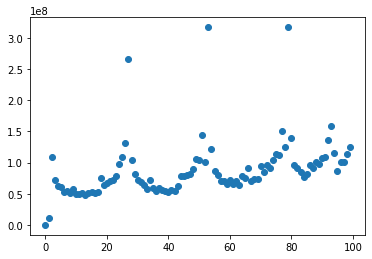

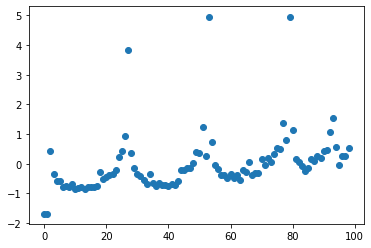

,Datetime,Volume
769,2022-03-11 13:15:00,50019000
770,2022-03-11 13:30:00,49186000
771,2022-03-11 13:45:00,57162000
772,2022-03-11 14:00:00,51230000
773,2022-03-11 14:15:00,53950000
774,2022-03-11 14:30:00,52291000
775,2022-03-11 14:45:00,60381000
776,2022-03-11 15:00:00,61670000
777,2022-03-11 15:15:00,71619000
778,2022-03-11 15:30:00,108435000


In [284]:
data = df_analisys.iloc[-100:,:]['Volume'].tolist()
data.reverse()
plt.scatter(range(0,len(data)), data)
plt.show()

data = df_vols_info_01.iloc[0,:][['ss1_vols_' + str(x) for x in range(1,100) ]]
plt.scatter(range(0,len(data)), data)
plt.show()

df_analisys[['Datetime','Volume']].iloc[-12:,]

In [285]:
# Create variable names lists to naming columns

ls_ss1vars = ['ss1_vols_' + str(x) for x in range(100,0,-1)]
len(ls_ss1vars)


100

In [286]:
#Assigns correct format to variable to apply transformations

df_vols_info_01[ls_ss1vars] = df_vols_info_01[ls_ss1vars].astype(float)
df_vols_info_01[ls_columns] = df_vols_info_01[ls_columns].astype(float)


In [287]:
df_vols_info_01 = df_vols_info_01[df_vols_info_01.notna().all(axis=1)]
df_vols_info_01 = df_vols_info_01.reset_index(drop=True)
print(df_vols_info_01.shape)

df_vols_info_01.info()



(682, 104)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Columns: 104 entries, ss1_vols_100 to Datetime
dtypes: datetime64[ns](1), float64(103)
memory usage: 554.2 KB


In [288]:
#Defines X vector to all process

X = df_vols_info_01[ls_ss1vars + ls_columns]
print(X.shape)


(682, 103)


In [289]:
# Defines the column trasformer
# This will be the standard schema : start with the pipeline for column transformers and then fit the model

#First a lil pip to treat imputation and scalation in one shot for numerical variables


pca_pip = Pipeline(steps=[('pca',PCA(n_components=3)),])


# Defines the column transformer
rf_transformer = ColumnTransformer([("passthrough", "passthrough", ls_columns),
                                     ("pca1", pca_pip, ls_ss1vars),
                                        ]) 

#Prepares pip
pip = Pipeline([('preprocessing', rf_transformer),])


#Fits the pipeline to the data
Xtr = rf_transformer.fit_transform(X)

#Saves the total procedure
#pickle.dump(kmeans_proc, open( DIRECTORY + 'kmeans_proc.pkl', 'wb'))

In [290]:
Xtr.shape

(682, 6)

In [291]:
#Defines the df of all transformations

ls_ss1pcavars = ['ss1_vols_c1','ss1_vols_c2','ss1_vols_c3']

df_vols_info_tr_01 = pd.DataFrame(Xtr,columns=ls_columns + ls_ss1pcavars)
print(df_vols_info_tr_01.shape)
df_vols_info_tr_01

(682, 6)


,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3
0,-1.681627,-0.973733,-0.692564,0.788314,-3.812857,-2.432902
1,-1.725799,-0.563246,-0.673761,1.899917,-3.858514,-1.475775
2,0.395123,-0.220310,-0.662763,3.101645,-3.704131,0.146074
3,-0.424320,-0.578987,-0.710127,4.055084,-2.849942,1.938216
4,-0.654816,-0.731937,-0.734299,4.775963,-1.924519,3.203034
...,...,...,...,...,...,...
677,3.895610,1.443709,0.036421,2.009878,-5.540776,-1.736389
678,0.464351,0.090858,-0.107679,3.591203,-4.837971,0.060706
679,0.076468,-0.222628,-0.147199,4.726086,-3.803184,1.557852
680,-0.288954,-0.378984,-0.204427,5.634250,-2.610920,2.746819


In [292]:
# Concat the Datetime to the transformed data

df_vols_info_tr_01 = pd.concat([df_vols_info_01['Datetime'],df_vols_info_tr_01],axis=1)
df_vols_info_tr_01

,Datetime,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3
0,2022-03-11 15:46:21,-1.681627,-0.973733,-0.692564,0.788314,-3.812857,-2.432902
1,2022-03-11 15:45:00,-1.725799,-0.563246,-0.673761,1.899917,-3.858514,-1.475775
2,2022-03-11 15:30:00,0.395123,-0.220310,-0.662763,3.101645,-3.704131,0.146074
3,2022-03-11 15:15:00,-0.424320,-0.578987,-0.710127,4.055084,-2.849942,1.938216
4,2022-03-11 15:00:00,-0.654816,-0.731937,-0.734299,4.775963,-1.924519,3.203034
...,...,...,...,...,...,...,...
677,2022-02-02 15:45:00,3.895610,1.443709,0.036421,2.009878,-5.540776,-1.736389
678,2022-02-02 15:30:00,0.464351,0.090858,-0.107679,3.591203,-4.837971,0.060706
679,2022-02-02 15:15:00,0.076468,-0.222628,-0.147199,4.726086,-3.803184,1.557852
680,2022-02-02 15:00:00,-0.288954,-0.378984,-0.204427,5.634250,-2.610920,2.746819


In [293]:
pd.concat([df_vols_info_tr_01[['Datetime'] +ls_columns].iloc[0:1,:],
           df_vols_info_01[['Datetime'] +ls_columns].iloc[0:1,:]],axis=0)

,Datetime,last_ss_volume,mean_last3_ss_vols,pred_ss_vol
0,2022-03-11 15:46:21,-1.681627,-0.973733,-0.692564
0,2022-03-11 15:46:21,-1.681627,-0.973733,-0.692564


## (Volume) Additional calculations

In [294]:
#Computes Target signal

df_input = df_vols_info_tr_01.copy()
nro_rows = len(df_input)

for i in range(0,nro_rows):
#for i in range(0,3):
    
    vol_threshold = 0.2
    
    #Searches for the after indexes where the profit threshold is fullfilled 
    
    s_obs = df_input['last_ss_volume'].iloc[(i+1):]

    s_threshold = (s_obs > vol_threshold)
    idxs = s_threshold[s_threshold].index

    keepcols = ['Datetime','last_ss_volume']
    
    try:
        target_idx = [min(idxs)]
        df_data = df_input.iloc[df_input.index==target_idx[0]]
    except:
        target_idx = []
        df_data = pd.DataFrame(columns=keepcols)

    df_data = df_data[keepcols]
    
    Datetime = df_input['Datetime'][i]
    
    try:
        low_movs = len(s_obs[s_obs.index<=target_idx[0]])
    except:
        low_movs = 0

    dic_rencols = {
        'Datetime':'Datetime2',
        'last_ss_volume': 'last_ss_volume2',
    }

    df_data = df_data.rename(columns=dic_rencols)
    df_data['Datetime'] = Datetime
    df_data['movs_low_vols'] = low_movs

    if i == 0:
        df_low_movs =df_data.copy()
    else:
        df_low_movs =df_low_movs.append(df_data).copy()


        
df_movs_low_vols = df_low_movs.reset_index(drop=True)
df_movs_low_vols

,Datetime2,last_ss_volume2,Datetime,movs_low_vols
0,2022-03-11 15:30:00,0.395123,2022-03-11 15:46:21,2
1,2022-03-11 15:30:00,0.395123,2022-03-11 15:45:00,1
2,2022-03-11 09:30:00,0.571487,2022-03-11 15:30:00,24
3,2022-03-11 09:30:00,0.571487,2022-03-11 15:15:00,23
4,2022-03-11 09:30:00,0.571487,2022-03-11 15:00:00,22
...,...,...,...,...
673,2022-02-03 10:00:00,0.510614,2022-02-03 10:15:00,1
674,2022-02-03 09:45:00,0.718459,2022-02-03 10:00:00,1
675,2022-02-03 09:30:00,0.404767,2022-02-03 09:45:00,1
676,2022-02-02 15:45:00,3.895610,2022-02-03 09:30:00,1


# Trading insights

In [295]:
for c in df_analisys.columns.tolist():
    print(c)

Datetime
Open
High
Low
Close
Adj Close
Volume
date
body_size
abs_body_size
upper_tail_size
lower_tail_size
body_disposal
MACD_12_26_9
MACDh_12_26_9
MACDs_12_26_9
diff_ewm50
diff_ewm200


In [296]:
# Prepares previos moements info as input variables
pd.options.mode.chained_assignment = None  # default='warn'


for i in range(0,len(df_analisys)):
#for i in range(0,1):
    
    ###############################################################################################
    nro_close_lag = 28
    
    ls_vars = [
        'Datetime',
        'Close',
        'Volume',
        'abs_body_size',
        'upper_tail_size',
        'lower_tail_size',
        'body_disposal',
        'MACD_12_26_9',
        'MACDs_12_26_9',
        'MACDh_12_26_9',
    ]
    
    
    df_input = df_analisys[ls_vars]
    
    ls_results = []

    if i==0:
        X = df_input.iloc[-(nro_close_lag + i):,:]
        Datetime = df_input.iloc[-1:,]['Datetime'].iloc[0]
    else:
        X = df_input.iloc[-(nro_close_lag + i):-i,:]
        Datetime = df_input.iloc[-(i+1):,]['Datetime'].iloc[0]
        
    if X.loc[max(X.index)]['Volume'] == 0:
        val = X.loc[max(X.index)-1]['Volume']
        X.loc[max(X.index),'Volume'] = val

    ###############################################################################################

    
    ###############################################################################################
    #Computes slopes before the last close
    
    def weighted_preds(Xp,var,var_weight):
    
        Xp['weight1'] = 1/len(X)
        Xp['weight1'] = Xp['weight1'].cumsum()
        Xp['weight1'] = Xp['weight1']/sum(Xp['weight1'])

        Xp['weight2'] = Xp[var_weight]/sum(Xp[var_weight])

        Xp['weight'] = Xp['weight1']*Xp['weight2']
        Xp['weight'] = Xp['weight']/sum(Xp['weight'])

        y = Xp[var].values.reshape(-1, 1)
        w = Xp['weight'].values.reshape(len(Xp),)
        x = np.array([range(0,len(Xp))]).reshape(-1, 1)

        linreg = LinearRegression()

        linreg.fit(x,y,w)
        slope_close = linreg.coef_[0][0]
        yhat = linreg.predict(x)

        Xp['yhat'] = yhat
        Xp['yhat_sup'] = yhat + yhat.std()
        Xp['yhat_inf'] = yhat - yhat.std()
        Xp['slope'] = math.atan(slope_close)*(180/math.pi)

        Xo = Xp[['yhat','yhat_sup','yhat_inf','slope']]

        return Xo

    Xp = X[['Close','Volume']]
    Xout = weighted_preds(Xp,'Close','Volume')
    
    Xout = Xout.rename(columns={'yhat':'pred_close_long',
                                'yhat_sup':'pred_close_long_upper',
                                'yhat_inf':'pred_close_long_lower',
                                'slope':'slope_close_long'})

    Xout = pd.concat([Xp,Xout],axis=1)


    Xp = X.iloc[-8:]
    Xout2 = weighted_preds(Xp,'Close','Volume')
    Xout2 = Xout2[['yhat','slope']].rename(columns={'yhat':'pred_close_short',
                                                    'slope':'slope_close_short'})

    Xout = pd.concat([Xout,Xout2],axis=1)
    Xout['slope_close_prom'] = (Xout['slope_close_long'] + Xout['slope_close_short'])/2



    actual_close = X['Close'].values[-1]
    pred_close_long = Xout['pred_close_long'].values[-1]
    pred_close_long_upper = Xout['pred_close_long_upper'].values[-1]
    pred_close_long_lower = Xout['pred_close_long_lower'].values[-1]
    
    slope_close_long = Xout['slope_close_long'].values[-1]
    slope_close_short = Xout['slope_close_short'].values[-1]
    
    diff_closewpred_close =  actual_close - pred_close_long
    pp_close_interval_distance = abs(diff_closewpred_close)/abs(pred_close_long_upper-pred_close_long)
    
    ls_results.append(slope_close_long)
    ls_results.append(slope_close_short)
    ls_results.append(diff_closewpred_close)
    ls_results.append(pp_close_interval_distance)
    
    ls_columns = [
        'slope_close_long',
        'slope_close_short',
        'diff_closewpred_close',
        'pp_close_interval_distance',
    ]
    ###############################################################################################
    
    
    
    ###############################################################################################
    df_macd_l4 = X[['MACD_12_26_9','MACDs_12_26_9','MACDh_12_26_9','Volume']].iloc[-5:,]

    df_macd_l4['neg'] = 0
    df_macd_l4.loc[df_macd_l4['MACDh_12_26_9']<0,'neg'] = 1

    df_macd_l4['pos'] = 0
    df_macd_l4.loc[df_macd_l4['MACDh_12_26_9']>=0,'pos'] = 1

    recent_macd_cross = 0
    if max(df_macd_l4['neg']) + max(df_macd_l4['pos']) == 2:
        recent_macd_cross = 1
        
    mean_last_macd = df_macd_l4['MACD_12_26_9'].mean()
    mean_last_macdh = df_macd_l4['MACDh_12_26_9'].mean()

        
    Xp = df_macd_l4
    
    try:
        Xout = weighted_preds(Xp,'MACD_12_26_9','Volume')

        slope = Xout['slope'].values
        slope_macd = slope[-1]
    except:
        slope = None
        slope_macd = None
    
    
    ls_results.append(recent_macd_cross)
    ls_results.append(slope_macd)
    ls_results.append(mean_last_macd)
    ls_results.append(mean_last_macdh)
    
    ls_columns = ls_columns + [
        'recent_macd_cross',
        'slope_macd',
        'mean_last_macd',
        'mean_last_macdh',
    ]
    ###############################################################################################
    
    

    ###############################################################################################
    #Computes pp for the associated volumes
    X['pp_vol'] = X['Volume'] / sum(X['Volume'])
    pp_vol_last2 = sum(X['pp_vol'].iloc[-2:])
    ls_results.append(pp_vol_last2)
    
    ls_columns = ls_columns + [
        'pp_vol_last2']
    ###############################################################################################
    
    
    
    ###############################################################################################
    # Joins the ss closes df with the slopes df
    df_results = pd.DataFrame(np.array([ls_results]),columns=ls_columns)
    df_results
    
    df_info = pd.concat([df_results],axis=1,sort=False)
    df_info['Datetime'] = Datetime
    
    if i == 0:
        df_info_01 = df_info.copy()
    else:
        df_info_01 = df_info_01.append(df_info,sort=False).copy()
    ###############################################################################################
        
df_info_01 = df_info_01.reset_index(drop=True)
df_info_01

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars


,slope_close_long,slope_close_short,diff_closewpred_close,pp_close_interval_distance,recent_macd_cross,slope_macd,mean_last_macd,mean_last_macdh,pp_vol_last2,Datetime
0,-62.67586,-79.973816,-6.905452,0.441689,0.0,-52.255867,-6.382626,-3.1407,0.010582,2022-03-11 15:46:21
1,-61.709792,-80.387377,-9.688593,0.645556,0.0,-53.503254,-5.156999,-2.700248,0.05744,2022-03-11 15:45:00
2,-60.666101,-79.448694,-10.44743,0.726806,0.0,-52.049865,-3.945885,-2.164196,0.084094,2022-03-11 15:30:00
3,-55.844519,-76.828751,-8.030113,0.674463,0.0,-46.239886,-2.874769,-1.634128,0.063318,2022-03-11 15:15:00
4,-52.440767,-74.712942,-8.211295,0.781684,0.0,-36.750529,-2.188321,-1.356213,0.058041,2022-03-11 15:00:00
...,...,...,...,...,...,...,...,...,...,...
776,70.537332,70.537332,-6.425209,1.605539,0,None,NaN,NaN,0.354084,2022-01-28 10:30:00
777,83.443438,83.443438,-0.996746,0.102467,0,None,NaN,NaN,0.463339,2022-01-28 10:15:00
778,84.652608,84.652608,2.268491,0.260055,0,None,NaN,NaN,0.751397,2022-01-28 10:00:00
779,-69.106471,-69.106471,0.0,0.0,0,None,NaN,NaN,1.0,2022-01-28 09:45:00


In [297]:
df_insights_info_tr_01 = df_info_01.copy()
print(df_insights_info_tr_01.shape)

(781, 10)


In [298]:
df_slopes_long = df_insights_info_tr_01[['Datetime','slope_close_long']]

slope_close_long_m1 = df_insights_info_tr_01['slope_close_long'].shift(-1)
slope_close_long_m2 = df_insights_info_tr_01['slope_close_long'].shift(-2)

df_insights_info_tr_01['slope_close_long_changerate_m0'] = df_slopes_long['slope_close_long'] -slope_close_long_m1
df_insights_info_tr_01['slope_close_long_changerate_m1'] = slope_close_long_m1 - slope_close_long_m2
df_insights_info_tr_01['slope_close_long_changerate_diff'] = df_insights_info_tr_01['slope_close_long_changerate_m0'] - df_insights_info_tr_01['slope_close_long_changerate_m1']

df_insights_info_tr_01[['Datetime',
                        'slope_close_long',
                        'slope_close_long_changerate_m0',
                        'slope_close_long_changerate_m1',
                        'slope_close_long_changerate_diff']]

,Datetime,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff
0,2022-03-11 15:46:21,-62.67586,-0.966068,-1.043691,0.077623
1,2022-03-11 15:45:00,-61.709792,-1.043691,-4.821583,3.777892
2,2022-03-11 15:30:00,-60.666101,-4.821583,-3.403752,-1.417831
3,2022-03-11 15:15:00,-55.844519,-3.403752,-3.730889,0.327137
4,2022-03-11 15:00:00,-52.440767,-3.730889,-2.725461,-1.005428
...,...,...,...,...,...
776,2022-01-28 10:30:00,70.537332,-12.906106,-1.209171,-11.696936
777,2022-01-28 10:15:00,83.443438,-1.209171,153.75908,-154.96825
778,2022-01-28 10:00:00,84.652608,153.75908,-69.106471,222.865551
779,2022-01-28 09:45:00,-69.106471,-69.106471,NaN,NaN


In [299]:
df_insights_info_tr_01.iloc[0:20,:][[
    'Datetime',
    'slope_close_long',
    'slope_close_long_changerate_m0',
    'slope_close_long_changerate_m1',
    'slope_close_long_changerate_diff',
    'slope_close_short',
    'diff_closewpred_close',
    'pp_close_interval_distance',
    'slope_macd',
    'mean_last_macd',
    'mean_last_macdh',
    'recent_macd_cross',
]]

,Datetime,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff,slope_close_short,diff_closewpred_close,pp_close_interval_distance,slope_macd,mean_last_macd,mean_last_macdh,recent_macd_cross
0,2022-03-11 15:46:21,-62.67586,-0.966068,-1.043691,0.077623,-79.973816,-6.905452,0.441689,-52.255867,-6.382626,-3.1407,0.0
1,2022-03-11 15:45:00,-61.709792,-1.043691,-4.821583,3.777892,-80.387377,-9.688593,0.645556,-53.503254,-5.156999,-2.700248,0.0
2,2022-03-11 15:30:00,-60.666101,-4.821583,-3.403752,-1.417831,-79.448694,-10.44743,0.726806,-52.049865,-3.945885,-2.164196,0.0
3,2022-03-11 15:15:00,-55.844519,-3.403752,-3.730889,0.327137,-76.828751,-8.030113,0.674463,-46.239886,-2.874769,-1.634128,0.0
4,2022-03-11 15:00:00,-52.440767,-3.730889,-2.725461,-1.005428,-74.712942,-8.211295,0.781684,-36.750529,-2.188321,-1.356213,0.0
5,2022-03-11 14:45:00,-48.709878,-2.725461,-2.124225,-0.601236,-66.610466,-4.225124,0.459357,-21.187946,-1.665821,-1.172766,0.0
6,2022-03-11 14:30:00,-45.984417,-2.124225,1.211807,-3.336032,-46.626217,-1.741286,0.208283,-11.602327,-1.252246,-1.052382,0.0
7,2022-03-11 14:15:00,-43.860192,1.211807,-2.801612,4.013419,10.945813,7.580101,0.976492,-8.264968,-1.075756,-1.138988,0.0
8,2022-03-11 14:00:00,-45.071999,-2.801612,-5.78494,2.983328,-10.365294,-0.454355,0.056107,-10.015069,-1.12605,-1.474029,0.0
9,2022-03-11 13:45:00,-42.270387,-5.78494,-1.944597,-3.840343,37.240748,-3.915026,0.533197,2.157985,-1.049236,-1.765722,0.0


In [300]:

def weighted_preds(Xp,var,var_weight):
    
    Xp['weight1'] = 1/len(X)
    Xp['weight1'] = Xp['weight1'].cumsum()
    Xp['weight1'] = Xp['weight1']/sum(Xp['weight1'])

    Xp['weight2'] = Xp[var_weight]/sum(Xp[var_weight])

    Xp['weight'] = Xp['weight1']*Xp['weight2']
    Xp['weight'] = Xp['weight']/sum(Xp['weight'])

    y = Xp[var].values.reshape(-1, 1)
    w = Xp['weight'].values.reshape(len(Xp),)
    x = np.array([range(0,len(Xp))]).reshape(-1, 1)

    linreg = LinearRegression()

    linreg.fit(x,y,w)
    slope_close = linreg.coef_[0][0]
    yhat = linreg.predict(x)

    Xp['yhat'] = yhat
    Xp['yhat_sup'] = yhat + yhat.std()
    Xp['yhat_inf'] = yhat - yhat.std()
    Xp['slope'] = math.atan(slope_close)*(180/math.pi)

    Xo = Xp[['yhat','yhat_sup','yhat_inf','slope']]

    return Xo

i=2

if i==0:
    Xp = df_analisys[['Close','Volume']].iloc[-(21 + i):]
    Datetime = df_analisys[['Datetime']].iloc[-(21 + i):]
else:
    Xp = df_analisys[['Close','Volume']].iloc[-(21 + i):-i]
    Datetime = df_analisys[['Datetime']].iloc[-(21 + i):-i]

Xout = weighted_preds(Xp,'Close','Volume')
Xout = Xout.rename(columns={'yhat':'pred_close_long',
                            'yhat_sup':'pred_close_long_sup',
                            'yhat_inf':'pred_close_long_inf',
                            'slope':'slope_close_long'})


Xout = pd.concat([Xp,Xout],axis=1)

if i==0:
    Xp = df_analisys[['Close','Volume']].iloc[-(8+i):]
else:
    Xp = df_analisys[['Close','Volume']].iloc[-(8+i):-i]
    
Xout2 = weighted_preds(Xp,'Close','Volume')
Xout2 = Xout2[['yhat','slope']].rename(columns={'yhat':'pred_close_short','slope':'slope_close_short'})

Xout = pd.concat([Xout,Xout2],axis=1)
Xout['slope_close_prom'] = (Xout['slope_close_long'] + Xout['slope_close_short'])/2

#Xout

2022-03-11 15:46:21
2022-03-11 15:30:00


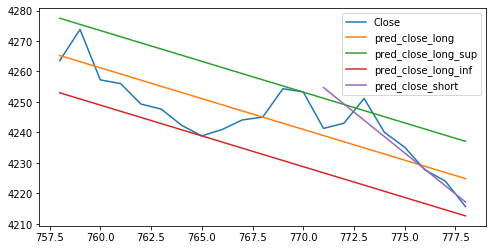

In [301]:
df_obs = Xout[['Close','pred_close_long','pred_close_long_sup','pred_close_long_inf','pred_close_short']]

print(max(df_analisys['Datetime']))
print(max(Datetime['Datetime']))
df_obs.plot(figsize=(8,4))

In [302]:
df_insights_info_tr_01.iloc[9:21,:][[
    'Datetime',
    'slope_close_long',
    'slope_close_long_changerate_m0',
    'slope_close_long_changerate_m1',
    'slope_close_short',
    'diff_closewpred_close',
    'pp_close_interval_distance',
    'slope_macd',
    'mean_last_macd',
    'mean_last_macdh',
    'recent_macd_cross',
]]

,Datetime,slope_close_long,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_short,diff_closewpred_close,pp_close_interval_distance,slope_macd,mean_last_macd,mean_last_macdh,recent_macd_cross
9,2022-03-11 13:45:00,-42.270387,-5.78494,-1.944597,37.240748,-3.915026,0.533197,2.157985,-1.049236,-1.765722,0.0
10,2022-03-11 13:30:00,-36.485448,-1.944597,-2.764491,66.71492,5.38072,0.900683,9.859514,-0.958742,-2.116659,0.0
11,2022-03-11 13:15:00,-34.540851,-2.764491,-10.632976,52.767685,5.718749,1.028521,-8.68424,-0.821756,-2.508838,0.0
12,2022-03-11 13:00:00,-31.77636,-10.632976,-14.718207,-36.225531,-4.383773,0.876088,-31.450667,-0.341318,-2.655609,0.0
13,2022-03-11 12:45:00,-21.143384,-14.718207,-20.677152,-62.381998,-8.117015,2.598299,-43.334876,0.520817,-2.457376,0.0
14,2022-03-11 12:30:00,-6.425177,-20.677152,-20.360848,-74.303209,-14.380074,15.808204,-50.276124,1.559876,-2.032661,0.0
15,2022-03-11 12:15:00,14.251975,-20.360848,-13.335134,-77.281037,-20.423419,9.953987,-52.059955,2.757519,-1.343184,1.0
16,2022-03-11 12:00:00,34.612823,-13.335134,-7.957988,-76.296299,-21.358077,3.830954,-49.854754,3.938953,-0.497546,1.0
17,2022-03-11 11:45:00,47.947957,-7.957988,-6.720845,-72.480678,-19.776772,2.208492,-46.368543,5.015715,0.454829,1.0
18,2022-03-11 11:30:00,55.905945,-6.720845,-3.033339,-70.139454,-20.826275,1.745202,-37.493406,5.677275,1.230097,1.0


In [303]:
df_obs = df_insights_info_tr_01[df_insights_info_tr_01.notna().all(axis=1)==False]

df_obs

,slope_close_long,slope_close_short,diff_closewpred_close,pp_close_interval_distance,recent_macd_cross,slope_macd,mean_last_macd,mean_last_macdh,pp_vol_last2,Datetime,slope_close_long_changerate_m0,slope_close_long_changerate_m1,slope_close_long_changerate_diff
748,80.159626,76.694635,-1.685525,0.036194,0.0,43.399847,32.502236,NaN,0.060525,2022-01-31 11:00:00,0.33406,0.510272,-0.176211
749,79.825566,81.001005,7.04086,0.156431,0.0,57.369304,31.043377,NaN,0.065145,2022-01-31 10:45:00,0.510272,0.588598,-0.078326
750,79.315294,83.083759,10.582197,0.247173,0.0,64.577443,29.04341,NaN,0.070115,2022-01-31 10:30:00,0.588598,0.654702,-0.066104
751,78.726696,84.747522,15.642941,0.386022,0.0,69.769656,26.655361,NaN,0.076589,2022-01-31 10:15:00,0.654702,1.100689,-0.445988
752,78.071994,85.781125,27.245828,0.712514,0,None,25.39814,NaN,0.08234,2022-01-31 10:00:00,1.100689,1.081453,0.019236
753,76.971305,85.984299,23.089555,0.661425,0,None,23.900621,NaN,0.075258,2022-01-31 09:45:00,1.081453,0.814347,0.267106
754,75.889852,86.256405,20.454274,0.660122,0,None,22.450854,NaN,0.158525,2022-01-31 09:30:00,0.814347,8.883418,-8.069071
755,75.075505,86.147727,22.888405,0.813415,0,None,21.007493,NaN,0.179506,2022-01-28 15:45:00,8.883418,5.921872,2.961546
756,66.192087,83.637946,16.727081,1.023461,0,None,NaN,NaN,0.099194,2022-01-28 15:30:00,5.921872,3.330468,2.591404
757,60.270215,79.107185,8.688491,0.716799,0,None,NaN,NaN,0.0822,2022-01-28 15:15:00,3.330468,0.733053,2.597415


In [304]:
#df.index[np.isinf(df).any(1)]

df_insights_info_tr_01 = df_insights_info_tr_01[df_insights_info_tr_01.notna().all(axis=1)]
df_insights_info_tr_01 = df_insights_info_tr_01.reset_index(drop=True)
print(df_insights_info_tr_01.shape)

df_insights_info_tr_01.info()

(748, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   slope_close_long                  748 non-null    object        
 1   slope_close_short                 748 non-null    object        
 2   diff_closewpred_close             748 non-null    object        
 3   pp_close_interval_distance        748 non-null    object        
 4   recent_macd_cross                 748 non-null    object        
 5   slope_macd                        748 non-null    object        
 6   mean_last_macd                    748 non-null    object        
 7   mean_last_macdh                   748 non-null    object        
 8   pp_vol_last2                      748 non-null    object        
 9   Datetime                          748 non-null    datetime64[ns]
 10  slope_close_long_changerate_m0    748 no

# Target signal

In [305]:
df_analisys = df_analisys.sort_values(['Datetime'])
df_analisys = df_analisys.reset_index(drop=True)
print(df_analisys.shape)

(781, 18)


In [306]:
#Computes Target signal

nro_rows = len(df_analisys)
for i in range(0,nro_rows):
    
    nro_steps = 2
    
    try:
        #Searches for the after indexes where the profit threshold is fullfilled 
        
        Datetime = df_analisys['Datetime'][i]
        target_date = df_analisys['Datetime'][i+nro_steps]
        
        target_close = df_analisys['Close'].iloc[i+nro_steps]
        target_profit =  target_close - df_analisys['Close'][i]


        
        
        ls_results = [Datetime,target_date,target_close,target_profit]
        df_results = pd.DataFrame(np.array([ls_results]),columns=['Datetime','target_date','target_close','target_profit'])
        
        
        if i == 0:
            df_target =df_results.copy()
        else:
            df_target =df_target.append(df_results).copy()
            
    except:
        pass
        
df_target = df_target.reset_index(drop=True)
df_target

,Datetime,target_date,target_close,target_profit
0,2022-01-28 09:30:00,2022-01-28 10:00:00,4315.200195,15.130371
1,2022-01-28 09:45:00,2022-01-28 10:15:00,4318.759766,21.30957
2,2022-01-28 10:00:00,2022-01-28 10:30:00,4307.200195,-8.0
3,2022-01-28 10:15:00,2022-01-28 10:45:00,4346.759766,28.0
4,2022-01-28 10:30:00,2022-01-28 11:00:00,4354.939941,47.739746
...,...,...,...,...
774,2022-03-11 14:30:00,2022-03-11 15:00:00,4227.700195,-12.349609
775,2022-03-11 14:45:00,2022-03-11 15:15:00,4224.069824,-11.080078
776,2022-03-11 15:00:00,2022-03-11 15:30:00,4215.669922,-12.030273
777,2022-03-11 15:15:00,2022-03-11 15:45:00,4213.919922,-10.149902


In [307]:
df_analisys_01 = pd.merge(df_analisys,
                         df_target,
                         on = ['Datetime'],
                         how = 'left').copy()

print(df_analisys.shape)
print(df_analisys_01.shape)

print(df_analisys_01['target_profit'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))

df_analisys_01

(781, 18)
(781, 21)
         index  target_profit
182 -94.220215              1
410 -71.140137              1
473 -62.959961              1
181 -61.430176              1
633 -58.369629              1
..         ...            ...
231  59.790039              1
244  66.729980              1
230  69.750000              1
245  75.219727              1
1          NaN              2

[743 rows x 2 columns]


,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,lower_tail_size,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200,target_date,target_close,target_profit
0,2022-01-28 09:30:00,4336.189941,4342.990234,4299.500000,4300.069824,4300.069824,100494632,2022-01-28,-36.120117,36.120117,...,0.569824,0,NaN,NaN,NaN,NaN,NaN,2022-01-28 10:00:00,4315.200195,15.130371
1,2022-01-28 09:45:00,4300.040039,4310.029785,4292.979980,4297.450195,4297.450195,178147219,2022-01-28,-2.589844,2.589844,...,4.470215,0,NaN,NaN,NaN,NaN,NaN,2022-01-28 10:15:00,4318.759766,21.30957
2,2022-01-28 10:00:00,4298.410156,4320.919922,4292.459961,4315.200195,4315.200195,125595455,2022-01-28,16.790039,16.790039,...,5.950195,1,NaN,NaN,NaN,NaN,NaN,2022-01-28 10:30:00,4307.200195,-8.0
3,2022-01-28 10:15:00,4315.509766,4335.979980,4314.470215,4318.759766,4318.759766,114976511,2022-01-28,3.250000,3.250000,...,1.039551,1,NaN,NaN,NaN,NaN,NaN,2022-01-28 10:45:00,4346.759766,28.0
4,2022-01-28 10:30:00,4319.660156,4325.729980,4305.479980,4307.200195,4307.200195,106622310,2022-01-28,-12.459961,12.459961,...,1.720215,0,NaN,NaN,NaN,NaN,NaN,2022-01-28 11:00:00,4354.939941,47.739746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2022-03-11 15:00:00,4235.319824,4235.560059,4227.129883,4227.700195,4227.700195,61670000,2022-03-11,-7.619629,7.619629,...,0.570312,0,-3.807217,-2.172065,-1.635153,-20.278236,-44.742725,2022-03-11 15:30:00,4215.669922,-12.030273
777,2022-03-11 15:15:00,4227.660156,4232.430176,4224.000000,4224.069824,4224.069824,71619000,2022-03-11,-3.590332,3.590332,...,0.069824,0,-5.001556,-2.693123,-2.308433,-22.971015,-47.891772,2022-03-11 15:45:00,4213.919922,-10.149902
778,2022-03-11 15:30:00,4224.029785,4224.029785,4214.399902,4215.669922,4215.669922,108435000,2022-03-11,-8.359863,8.359863,...,1.270020,0,-6.550371,-3.393550,-3.156821,-30.140685,-55.731558,2022-03-11 15:46:21,4214.120117,-1.549805
779,2022-03-11 15:45:00,4215.759766,4217.229980,4213.859863,4213.919922,4213.919922,10454000,2022-03-11,-1.839844,1.839844,...,0.060059,0,-7.828783,-3.737570,-4.091213,-30.640070,-56.909603,NaT,NaN,NaN


In [308]:
df_analisys_01[['Close','target_close','target_profit']]

,Close,target_close,target_profit
0,4300.069824,4315.200195,15.130371
1,4297.450195,4318.759766,21.30957
2,4315.200195,4307.200195,-8.0
3,4318.759766,4346.759766,28.0
4,4307.200195,4354.939941,47.739746
...,...,...,...
776,4227.700195,4215.669922,-12.030273
777,4224.069824,4213.919922,-10.149902
778,4215.669922,4214.120117,-1.549805
779,4213.919922,NaN,NaN


In [309]:
df_varbins = df_analisys_01[['target_profit']]
df_varbins['target_bins'] = pd.qcut(df_varbins['target_profit'], 20, duplicates='drop')
df_varbins['target_bins'] = df_varbins['target_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_bins'].astype(str)

print(df_varbins['target_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                    index  target_bins
20                 00-nan            2
7   01-(-94.221, -25.248]           39
8   02-(-25.248, -19.688]           39
3   03-(-19.688, -14.485]           39
14  04-(-14.485, -10.918]           39
12   05-(-10.918, -8.835]           39
17     06-(-8.835, -7.03]           39
13     07-(-7.03, -4.958]           39
6     08-(-4.958, -2.872]           39
5     09-(-2.872, -1.159]           39
10      10-(-1.159, 0.58]           39
19       11-(0.58, 2.097]           38
0        12-(2.097, 3.69]           40
18       13-(3.69, 5.015]           38
4       14-(5.015, 6.662]           39
9        15-(6.662, 8.37]           39
11      16-(8.37, 10.858]           39
15    17-(10.858, 13.099]           39
1     18-(13.099, 17.186]           39
2     19-(17.186, 24.835]           39
16     20-(24.835, 75.22]           39


In [310]:
mean_time = abs(df_varbins['target_profit']).mean()
print('Mean profit: ', mean_time)

Mean profit:  11.888416765284019


In [311]:
#Computes the target difference in transcurred time
df_analisys_01['target_date_diff'] =  df_analisys_01['target_date'] - df_analisys_01['Datetime']
df_analisys_01['target_date_diff'] = df_analisys_01['target_date_diff'] / np.timedelta64(1,'m')

df_analisys_01

,Datetime,Open,High,Low,Close,Adj Close,Volume,date,body_size,abs_body_size,...,body_disposal,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,diff_ewm50,diff_ewm200,target_date,target_close,target_profit,target_date_diff
0,2022-01-28 09:30:00,4336.189941,4342.990234,4299.500000,4300.069824,4300.069824,100494632,2022-01-28,-36.120117,36.120117,...,0,NaN,NaN,NaN,NaN,NaN,2022-01-28 10:00:00,4315.200195,15.130371,30.00
1,2022-01-28 09:45:00,4300.040039,4310.029785,4292.979980,4297.450195,4297.450195,178147219,2022-01-28,-2.589844,2.589844,...,0,NaN,NaN,NaN,NaN,NaN,2022-01-28 10:15:00,4318.759766,21.30957,30.00
2,2022-01-28 10:00:00,4298.410156,4320.919922,4292.459961,4315.200195,4315.200195,125595455,2022-01-28,16.790039,16.790039,...,1,NaN,NaN,NaN,NaN,NaN,2022-01-28 10:30:00,4307.200195,-8.0,30.00
3,2022-01-28 10:15:00,4315.509766,4335.979980,4314.470215,4318.759766,4318.759766,114976511,2022-01-28,3.250000,3.250000,...,1,NaN,NaN,NaN,NaN,NaN,2022-01-28 10:45:00,4346.759766,28.0,30.00
4,2022-01-28 10:30:00,4319.660156,4325.729980,4305.479980,4307.200195,4307.200195,106622310,2022-01-28,-12.459961,12.459961,...,0,NaN,NaN,NaN,NaN,NaN,2022-01-28 11:00:00,4354.939941,47.739746,30.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2022-03-11 15:00:00,4235.319824,4235.560059,4227.129883,4227.700195,4227.700195,61670000,2022-03-11,-7.619629,7.619629,...,0,-3.807217,-2.172065,-1.635153,-20.278236,-44.742725,2022-03-11 15:30:00,4215.669922,-12.030273,30.00
777,2022-03-11 15:15:00,4227.660156,4232.430176,4224.000000,4224.069824,4224.069824,71619000,2022-03-11,-3.590332,3.590332,...,0,-5.001556,-2.693123,-2.308433,-22.971015,-47.891772,2022-03-11 15:45:00,4213.919922,-10.149902,30.00
778,2022-03-11 15:30:00,4224.029785,4224.029785,4214.399902,4215.669922,4215.669922,108435000,2022-03-11,-8.359863,8.359863,...,0,-6.550371,-3.393550,-3.156821,-30.140685,-55.731558,2022-03-11 15:46:21,4214.120117,-1.549805,16.35
779,2022-03-11 15:45:00,4215.759766,4217.229980,4213.859863,4213.919922,4213.919922,10454000,2022-03-11,-1.839844,1.839844,...,0,-7.828783,-3.737570,-4.091213,-30.640070,-56.909603,NaT,NaN,NaN,NaN


In [312]:
df_varbins = df_analisys_01[['target_date_diff']]
df_varbins['target_date_bins'] = pd.qcut(df_varbins['target_date_diff'], 20, duplicates='drop')
df_varbins['target_date_bins'] = df_varbins['target_date_bins'].cat.codes.apply(lambda x: "{:02d}".format(x+1)) + '-' + df_varbins['target_date_bins'].astype(str)

print(df_varbins['target_date_bins'].value_counts(dropna=False).reset_index().sort_values(['index']))

                 index  target_date_bins
3               00-nan                 2
0    01-(16.349, 30.0]               721
1    02-(30.0, 1080.0]                46
2  03-(1080.0, 5400.0]                12


In [313]:
# Computes high time to produce additional categories fo the target

df_varbins = df_varbins.sort_values(['target_date_diff'])
df_varbins = df_varbins[df_varbins.notna().all(axis=1)]
size = round(len(df_varbins)*(0.5))

high_time = df_varbins.iloc[size,:]['target_date_diff']
high_time

30.0

In [314]:
mean_time = df_varbins['target_date_diff'].mode()
print('Mean awaiting time to profit: ', mean_time)

Mean awaiting time to profit:  0    30.0
dtype: float64


In [315]:
#computes the target order movement
df_analisys_01['target_order'] = 'NULL'

df_analisys_01.loc[df_analisys_01['target_profit'] < 0, 'target_order'] = 'SELL'

df_analisys_01.loc[(df_analisys_01['target_profit'] < 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'SELL2'


df_analisys_01.loc[df_analisys_01['target_profit'] > 0, 'target_order'] = 'BUY'

df_analisys_01.loc[(df_analisys_01['target_profit'] > 0)
                   &(df_analisys_01['target_date_diff'] > high_time), 'target_order'] = 'BUY2'

df_analisys_01['target_order_bin'] = 0
df_analisys_01.loc[df_analisys_01['target_order'].isin(['BUY','BUY2']), 'target_order_bin'] = 1

print(df_analisys_01['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))
print(df_analisys_01['target_order_bin'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
0    BUY           371
2   BUY2            29
4   NULL             3
1   SELL           349
3  SELL2            29
   index  target_order_bin
1      0               381
0      1               400


# Attaches target variable to the df with transformations

In [316]:
ls_tgcols = [
    'date',
    'Datetime',
    'Close',
    'Volume',
    'target_order',
    'target_order_bin',
    'target_close',
    'target_profit',
    'target_date',
    'target_date_diff',
]




df_transformations_100 = pd.merge(df_vols_info_tr_01,
                           df_insights_info_tr_01,
                           on = ['Datetime'],
                           how='inner'
                         ).copy()


df_analisys_100 = pd.merge(df_transformations_100,
                           df_analisys_01[ls_tgcols],
                           on = ['Datetime'],
                           how='inner'
                         ).copy()


df_analisys_100 = df_analisys_100.sort_values(['Datetime']).reset_index(drop=True)

print(df_analisys_100.shape)

df_analisys_100


(682, 28)


,Datetime,last_ss_volume,mean_last3_ss_vols,pred_ss_vol,ss1_vols_c1,ss1_vols_c2,ss1_vols_c3,slope_close_long,slope_close_short,diff_closewpred_close,...,slope_close_long_changerate_diff,date,Close,Volume,target_order,target_order_bin,target_close,target_profit,target_date,target_date_diff
0,2022-02-02 14:45:00,-0.484460,-0.463177,-0.204486,6.102081,-1.219975,3.062425,57.528382,62.984519,0.170216,...,-0.692075,2022-02-02,4584.129883,63006000,BUY,1,4587.359863,3.22998,2022-02-02 15:15:00,30.00
1,2022-02-02 15:00:00,-0.288954,-0.378984,-0.204427,5.634250,-2.610920,2.746819,56.794858,62.431236,-0.296177,...,-0.009972,2022-02-02,4584.830078,72175000,BUY,1,4590.549805,5.719727,2022-02-02 15:30:00,30.00
2,2022-02-02 15:15:00,0.076468,-0.222628,-0.147199,4.726086,-3.803184,1.557852,56.510256,61.777106,0.73214,...,0.448921,2022-02-02,4587.359863,88881000,BUY,1,4587.72998,0.370117,2022-02-02 15:45:00,30.00
3,2022-02-02 15:30:00,0.464351,0.090858,-0.107679,3.591203,-4.837971,0.060706,56.882287,64.660972,1.911469,...,0.656635,2022-02-02,4590.549805,107046000,SELL2,0,4527.589844,-62.959961,2022-02-03 09:30:00,1080.00
4,2022-02-02 15:45:00,3.895610,1.443709,0.036421,2.009878,-5.540776,-1.736389,55.555594,49.264979,-1.316241,...,-1.698725,2022-02-02,4587.729980,286770000,SELL2,0,4516.589844,-71.140137,2022-02-03 09:45:00,1080.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,2022-03-11 15:00:00,-0.654816,-0.731937,-0.734299,4.775963,-1.924519,3.203034,-52.440767,-74.712942,-8.211295,...,-1.005428,2022-03-11,4227.700195,61670000,SELL,0,4215.669922,-12.030273,2022-03-11 15:30:00,30.00
678,2022-03-11 15:15:00,-0.424320,-0.578987,-0.710127,4.055084,-2.849942,1.938216,-55.844519,-76.828751,-8.030113,...,0.327137,2022-03-11,4224.069824,71619000,SELL,0,4213.919922,-10.149902,2022-03-11 15:45:00,30.00
679,2022-03-11 15:30:00,0.395123,-0.220310,-0.662763,3.101645,-3.704131,0.146074,-60.666101,-79.448694,-10.44743,...,-1.417831,2022-03-11,4215.669922,108435000,SELL,0,4214.120117,-1.549805,2022-03-11 15:46:21,16.35
680,2022-03-11 15:45:00,-1.725799,-0.563246,-0.673761,1.899917,-3.858514,-1.475775,-61.709792,-80.387377,-9.688593,...,3.777892,2022-03-11,4213.919922,10454000,NULL,0,NaN,NaN,NaT,NaN


In [317]:
print(df_analisys_100.shape)
print(min(df_analisys_100['Datetime']))
print(max(df_analisys_100['Datetime']))

(682, 28)
2022-02-02 14:45:00
2022-03-11 15:46:21


In [318]:
print(df_analisys_100['target_order'].value_counts(dropna=False).reset_index().sort_values(['index'],ascending = True))


   index  target_order
1    BUY           312
3   BUY2            24
4   NULL             3
0   SELL           315
2  SELL2            28


In [319]:
# SAVING POINT

DIR_OUTPUTS = r'C:\Users\willi\Documents\EJERCICIOS\TRADING\outputs/'

df_analisys_100.to_pickle(DIR_OUTPUTS + 'df_spx500_15m_s1' + '.pkl')
print(df_analisys_100.shape)
print(dt.datetime.now())

(682, 28)
2022-03-11 15:47:04.521511
